In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import argparse
import time
from tqdm import tqdm
import numpy as np
import os
import math
from os.path import join
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

In [5]:
def show(img, title='',cmap=None): 
    plt.figure(figsize=(15,10))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.show()

100%|██████████| 613/613 [00:08<00:00, 71.42it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


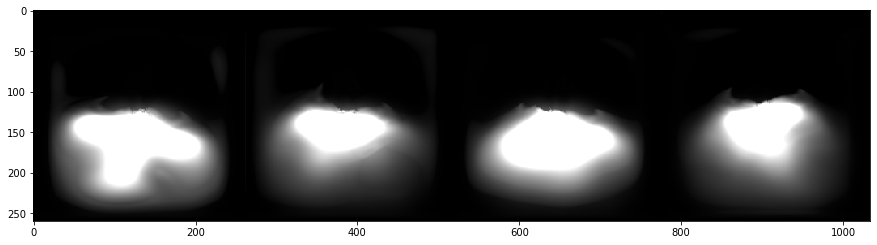

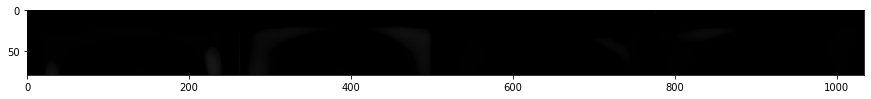

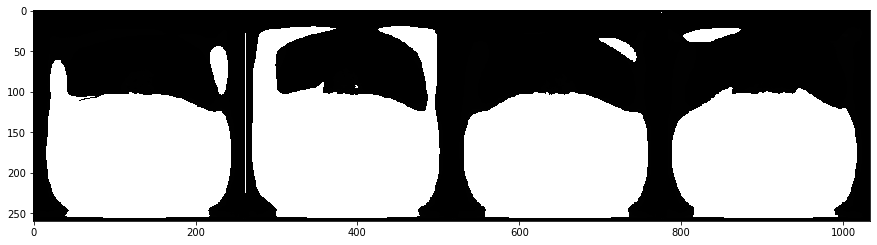

1193.1029


In [14]:
folder = './training_result/'
imgs = [join(folder, f) for f in os.listdir(folder) if os.path.isfile(join(folder, f))]
test_imgs = []
for i in imgs:
    if i.find('pred') != -1:
        test_imgs.append(i)

img_num = len(test_imgs)
final_ret = plt.imread(test_imgs[0])[:,:,:3]
for img in tqdm(test_imgs):
    img_np = plt.imread(img)[:,:,:3]
#     cur_vis = img_np[:80]
#     cur_vis[np.where(cur_vis > 1e-2)] = 1.0
    
#     if np.sum(img_np[:80]) > 1e-2:
#         print(np.sum(img_np[:80]))
#         show(cur_vis)
#         print(img)
        
    final_ret += img_np / img_num

vis = np.copy(final_ret)
vis[np.where(vis > 1e-2)] = 1.0
show(final_ret)
show(final_ret[:80])
show(vis)

print(np.sum(final_ret[:80]))

In [10]:
from ssn.ssn_dataset import SSN_Dataset
# from ssn.ssn_submodule import Contract
from ssn.ssn import Relight_SSN
from utils.net_utils import save_model

# device = torch.device('cpu')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda:0


In [4]:
# data set
ds_csv = "~/Dataset/soft_shadow/train/metadata.csv"
train_set = SSN_Dataset(ds_csv, True)
train_dataloder = DataLoader(train_set, batch_size=1, shuffle=False, num_workers=4)
valid_set = SSN_Dataset(ds_csv, False)
valid_dataloader = DataLoader(valid_set, batch_size=1, shuffle=False, num_workers=4)

Dataset initialize spent: 12.008753299713135 ms
Dataset initialize spent: 6.774827718734741 ms


In [13]:
from torchvision.utils import make_grid
    
model = Relight_SSN(1,1)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

# weight_file = os.path.join('weights', 'l1 loss_30-March-04-13-PM.pt')
# checkpoint = torch.load(weight_file, map_location=device)    
# model.to(device)
# model.load_state_dict(checkpoint['model_state_dict'])

23565493


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


range of prediction, min: 0.011112043634057045, max 3.0704264640808105
batch size: 1, total loss: 35.90242385864258, batch loss: 35.90242385864258
Image target: range: 0.0, 3.0
range of prediction, min: 1.2214098887852742e-06, max 16.40198516845703
batch size: 1, total loss: 23.41466522216797, batch loss: 23.41466522216797
Image target: range: 0.0, 1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


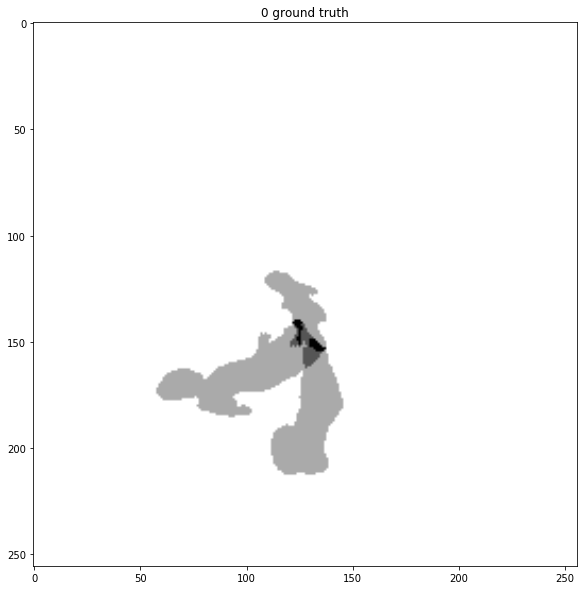

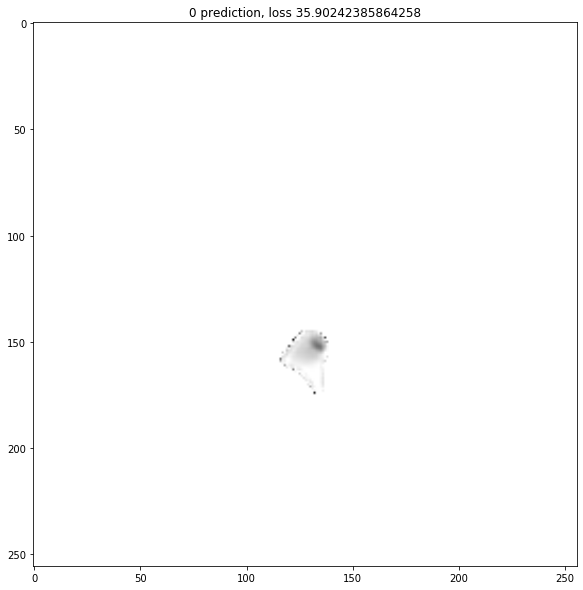

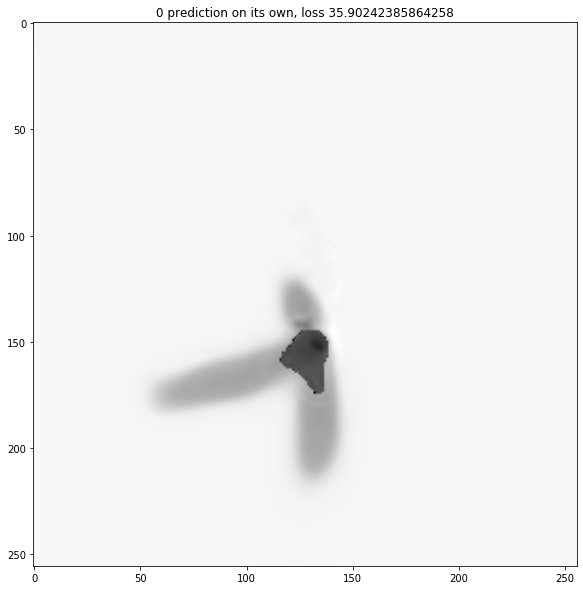

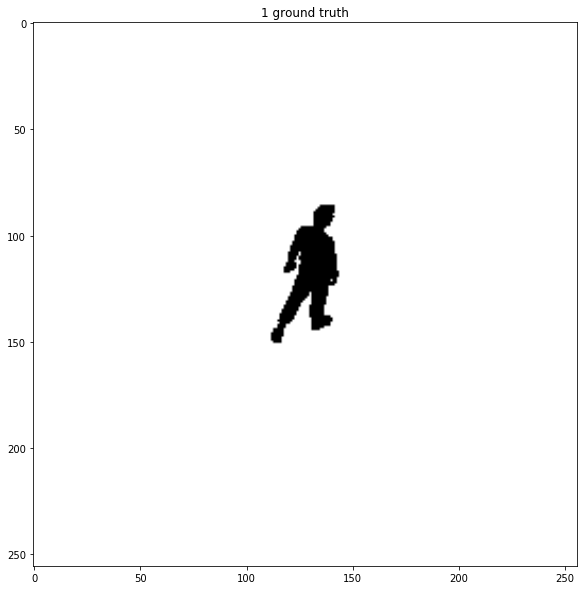

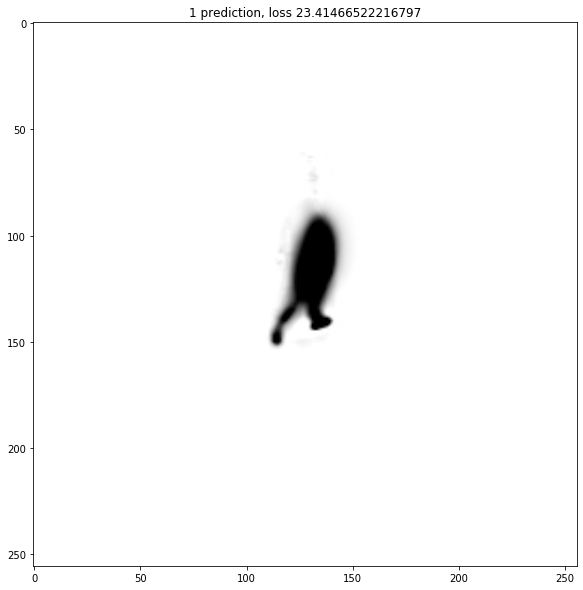

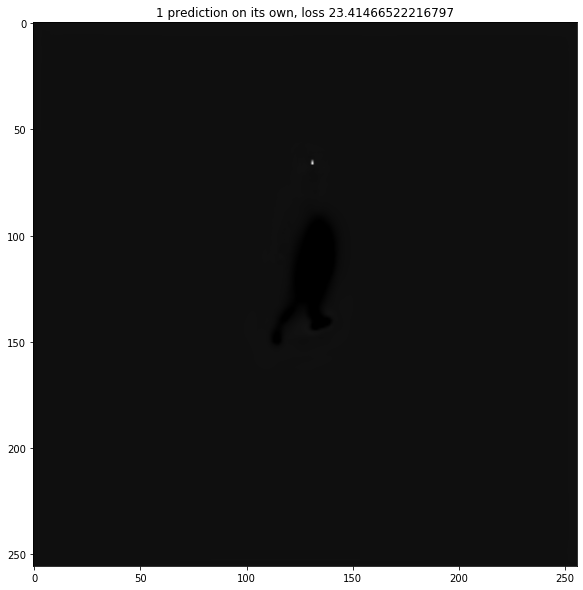

In [7]:
def show(img, title):
    plt.figure(figsize=(15,10))
    npimg = img.detach().cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='bilinear')
    plt.title(title)
    
def loss_func(gt, pred):
    return torch.norm((gt-predicted_img),2)

def normalize_batch(I_t, batch):
    b,h,w,c = batch.shape
    normalized_batch = batch.clone()
    for i in range(b):
        normalized_batch[i,:,:,:] = batch[i,:,:,:]/torch.max(I_t[i,:,:,:])
    
    return normalized_batch

counter = 0
with torch.no_grad():
    model.eval()
    for i, (mask, light, shadow) in enumerate(train_dataloder):            
        I_s, L_t, I_t = mask.to(device), light.to(device), shadow.to(device)
        predicted_img, predicted_src_light = model(I_s, L_t)
        
        # show(make_grid(predicted_src_light))
        
        b,h,w,c = I_s.shape
        total_loss = loss_func(I_t, predicted_img)
        avg_loss = total_loss / b
        print('range of prediction, min: {}, max {}'.format(torch.min(predicted_img), torch.max(predicted_img)))
        print('batch size: {}, total loss: {}, batch loss: {}'.format(b, total_loss, avg_loss))
        
        print('Image target: range: {}, {}'.format(torch.min(I_t), torch.max(I_t)))        
        I_t = normalize_batch(I_t, I_t)
        predict_img_It = normalize_batch(I_t, predicted_img)
        pred_img_ori = normalize_batch(predicted_img,predicted_img)
        
        show(make_grid(I_t),"{} ground truth".format(i))
        show(make_grid(predicted_img),"{} prediction, loss {}".format(i, avg_loss))
        show(make_grid(pred_img_ori),"{} prediction on its own, loss {}".format(i,avg_loss))
        
        counter += 1
        if counter > 1:
            break